Libraries

In [1]:
import lithops
from lidarpartitioner import create_partitions
import os
import shutil
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import laspy

Partitioning Variables

In [2]:
bucketPath = 'cos://lithops-testing/Catalonia/'
bucketName = 'lithops-testing'
partition_size = 500_000
buffer_size = 5

Total Cost Function

In [3]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

Function to download, partition and upload a file

In [4]:
def partitionCloudFile(obj, ibm_cos):
    filename = obj.key.split("/")[-1]
    
    #Make sure the file doesn't exist
    if os.path.exists("/tmp/" + filename):
        os.remove("/tmp/" + filename)

    #Download LIDAR file
    ibm_cos.download_file(bucketName, obj.key, "/tmp/" + filename)
    
    #Convert to .LAS if necessary
    if filename.endswith(".laz"):
        lidar = laspy.read("/tmp/" + filename)
        lidar = laspy.convert(lidar)
        filename = filename.split(".")[0] + ".las"
        lidar.write("/tmp/" + filename)
    
    #Make sure folder is empty
    if os.path.exists('/partitions'):
        shutil.rmtree('/partitions')

    #Create folder to store partitions
    os.makedirs('/partitions')

    #Create partitions
    create_partitions("/tmp/" + filename, '/partitions', partition_size, buffer_size)

    #Upload partitions to the Cloud
    for file in os.listdir("/partitions"):
        path = "/partitions/" + file
        destinationPath = "partitions/" + obj.key + "/" + file
        ibm_cos.upload_file(path, bucketName, destinationPath)
        
    return os.path.getsize("/tmp/" + filename)/(1024*1024)

Main

In [5]:
if __name__ == "__main__":
    fexec = lithops.FunctionExecutor(runtime='arnaugabriel/lithopspartitioner:1.0')
    fexec.map(partitionCloudFile, bucketPath)
    sizes = fexec.get_result()

2022-06-12 11:59:05,701 [INFO] lithops.config -- Lithops v2.6.0
2022-06-12 11:59:05,783 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: us-east
2022-06-12 11:59:05,784 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: lithops_testing_functions
2022-06-12 11:59:05,785 [INFO] lithops.invokers -- ExecutorID cf535e-0 | JobID M000 - Selected Runtime: arnaugabriel/lithopspartitioner:1.0 - 2048MB
2022-06-12 11:59:07,186 [INFO] lithops.invokers -- ExecutorID cf535e-0 | JobID M000 - Starting function invocation: partitionCloudFile() - Total: 516 activations
2022-06-12 11:59:07,653 [INFO] lithops.invokers -- ExecutorID cf535e-0 | JobID M000 - View execution logs at /tmp/lithops/logs/cf535e-0-M000.log
2022-06-12 11:59:07,660 [INFO] lithops.wait -- ExecutorID cf535e-0 - Getting results from 516 function activations


    0%|          | 0/516  

2022-06-12 12:01:24,009 [INFO] lithops.executors -- ExecutorID cf535e-0 - Cleaning temporary data


KPIs

In [6]:
    if not os.path.exists("plots"):
        os.makedirs("plots")
    fexec.plot(dst="plots/partition")

2022-06-12 12:01:24,357 [INFO] lithops.executors -- ExecutorID cf535e-0 - Creating execution plots


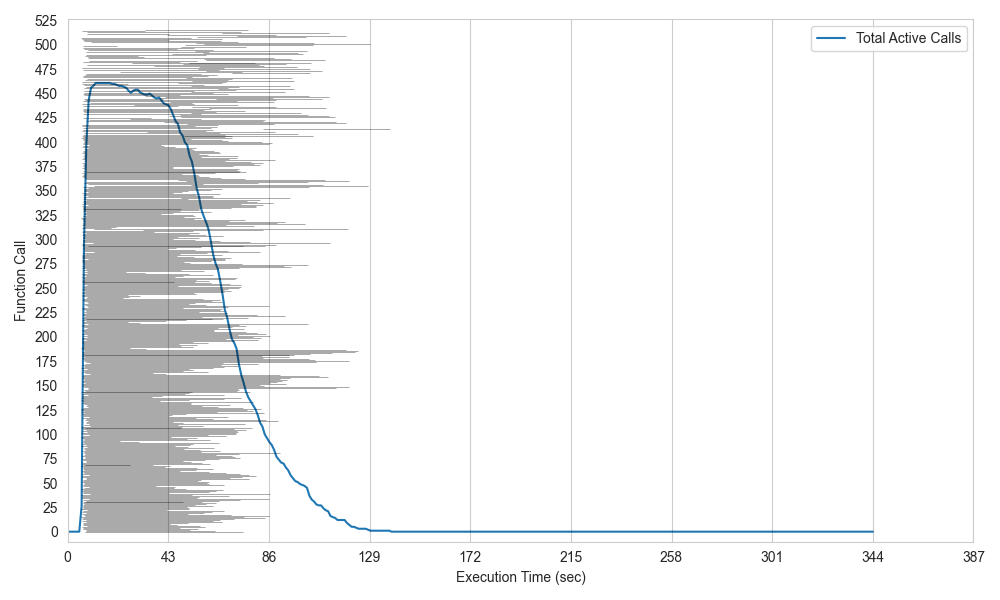

In [7]:
    Image(filename="plots/partition_histogram.png")

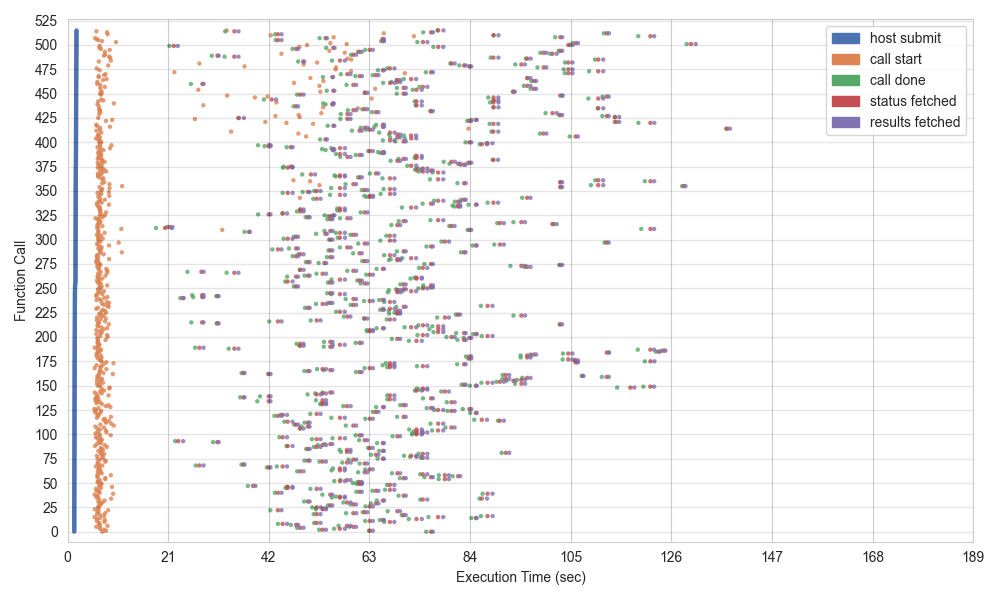

In [8]:
    Image(filename="plots/partition_timeline.png")

Data size

In [9]:
    data_size = sum(sizes)
    print(f"Data size: {data_size} MB")

Data size: 79340.4188079834 MB


KPI: Cost

In [10]:
    fexec.job_summary()
    pd.read_csv(fexec.log_path)

    cost_interpolation = get_process_cost(fexec)
    print(f"The experiment cost ${cost_interpolation:.4f}.")

2022-06-12 12:01:24,704 [INFO] lithops.executors -- View log file logs at /tmp/lithops/logs/2022-06-12_12:01:24.csv


The experiment cost $0.9911.


KPI: Throughput

In [11]:
    tstamps = set()
    for future in fexec.futures:
        for key in future.stats.keys():
            if key.endswith("tstamp"):
                tstamps.add(future.stats[key])

    duration = max(tstamps) - min(tstamps)
    print("Duration: " + str(duration) + " seconds")

    throughput_interpolation = data_size / duration

    print(f"Throughput: {throughput_interpolation} MB/s")

Duration: 138.22108221054077 seconds
Throughput: 574.0109796502004 MB/s
